### Install required libraries

In [1]:
# %pip install -r requirements.txt

### Prepare data

In [27]:
import numpy as np
from utils import onehot_encode


def stratified_split(val_ratio, data):
    classes = np.unique(data['target'])

    train_indices = []
    val_indices = []

    for cls in classes:

        cls_indices = np.where(data['target'] == cls)[0]

        # random state for reproducibility
        rng = np.random.RandomState(seed=18)
        cls_indices = rng.permutation(cls_indices)        
        val_size = int(len(cls_indices) * val_ratio)
        val_cls_indices = cls_indices[:val_size]
        train_cls_indices = cls_indices[val_size:]
        
        val_indices.extend(val_cls_indices)
        train_indices.extend(train_cls_indices)

    
    train_split = data[train_indices]
    val_split = data[val_indices]
    return train_split, val_split

def z_score_normmalize(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    x = (x - mean) / std
    return x

data = np.loadtxt(
    'dataset/2d.trn.dat', 
    skiprows=1,
    dtype=[('x', float), ('y', float), ('target', 'U1')]
)

test_data = np.loadtxt(
    'dataset/2d.tst.dat', 
    skiprows=1,
    dtype=[('x', float), ('y', float), ('target', 'U1')]
)

train_data, val_data = stratified_split(0.2, data)

X_train = z_score_normmalize(np.column_stack((train_data['x'], train_data['y']))).T
y_train = onehot_encode(train_data['target']).T

X_val = z_score_normmalize(np.column_stack((val_data['x'], val_data['y']))).T
y_val = onehot_encode(val_data['target']).T

X_test = z_score_normmalize(np.column_stack((test_data['x'], test_data['y']))).T
y_test = onehot_encode(test_data['target']).T

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2, 6401)
y_train shape (3, 6401)
X_val shape (2, 1599)
y_val shape (3, 1599)
X_test shape (2, 2000)
y_test shape (3, 2000)


## Train Neural Network

In [28]:
from neural_network import NeuralNetwork, Layer, ActivationFunction
from utils import compute_accuracy


nn = NeuralNetwork(
    layers=[
        Layer(ActivationFunction.relu, 12, input_dim=2),
        Layer(ActivationFunction.relu, 8),
        Layer(ActivationFunction.softmax, 3),
    ]
)

    
train_losses, val_losses = nn.train(X_train, y_train, lr=0.05, epochs=1000, X_val=X_val, y_val=y_val)
y_pred = nn.predict(X_test)
print(f"y_prede shape is {y_pred.shape}")
# print(compute_accuracy(y_test, y_pred))

Epoch 0 Loss: 7.572226
Epoch 1 Loss: 3.881095
Epoch 2 Loss: 1.868519
Epoch 3 Loss: 1.276081
Epoch 4 Loss: 1.133826
Epoch 5 Loss: 1.049982
Epoch 6 Loss: 0.995207
Epoch 7 Loss: 0.956283
Epoch 8 Loss: 0.926120
Epoch 9 Loss: 0.901007
Epoch 10 Loss: 0.879490
Epoch 11 Loss: 0.860686
Epoch 12 Loss: 0.843758
Epoch 13 Loss: 0.828509
Epoch 14 Loss: 0.814636
Epoch 15 Loss: 0.801917
Epoch 16 Loss: 0.790184
Epoch 17 Loss: 0.779182
Epoch 18 Loss: 0.768717
Epoch 19 Loss: 0.758601
Epoch 20 Loss: 0.748767
Epoch 21 Loss: 0.739117
Epoch 22 Loss: 0.729677
Epoch 23 Loss: 0.720528
Epoch 24 Loss: 0.711463
Epoch 25 Loss: 0.702568
Epoch 26 Loss: 0.693843
Epoch 27 Loss: 0.685351
Epoch 28 Loss: 0.677022
Epoch 29 Loss: 0.668874
Epoch 30 Loss: 0.660820
Epoch 31 Loss: 0.652930
Epoch 32 Loss: 0.645243
Epoch 33 Loss: 0.637664
Epoch 34 Loss: 0.630287
Epoch 35 Loss: 0.623130
Epoch 36 Loss: 0.616204
Epoch 37 Loss: 0.609455
Epoch 38 Loss: 0.602959
Epoch 39 Loss: 0.596712
Epoch 40 Loss: 0.590678
Epoch 41 Loss: 0.584800
Ep

## Plot loss vs epochs

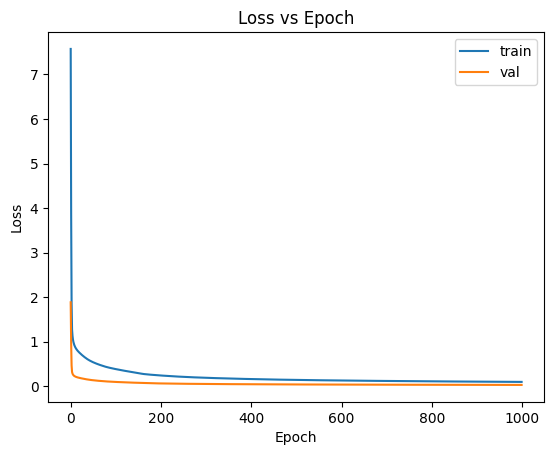

In [29]:
from matplotlib import pyplot as plt

plt.subplot(1, 1, 1)
plt.plot(train_losses,label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

In [ ]:
print(len(train_losses))
print(len(val_losses))

1000
0


## Plot confusion matrix

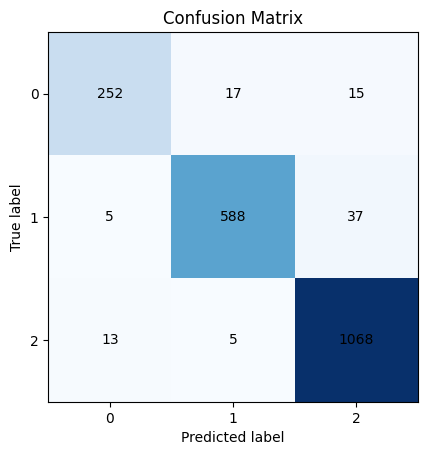

In [54]:
import numpy as np
import matplotlib.pyplot as plt

confusion_matrix = y_test @ y_pred.T

plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')

for i in range(3):
    for j in range(3):
        plt.text(j, i, str(int(confusion_matrix[i, j])), 
                 ha='center', va='center', color='black')

plt.xticks([0, 1, 2])
plt.yticks([0, 1, 2])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

## Plot classification

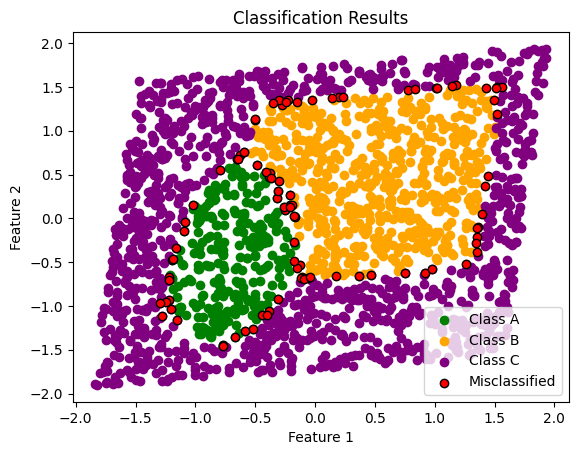

In [55]:
import matplotlib.pyplot as plt
import numpy as np

true_class = np.argmax(y_test, axis=0)
pred_class = np.argmax(y_pred, axis=0)

colors = np.where(pred_class != true_class, 'red', 'blue')

class_colors = ['green', 'orange', 'purple']

for i, color in enumerate(class_colors):
    class_indices = np.where(true_class == i)[0]
    plt.scatter(X_test[0, class_indices], X_test[1, class_indices], color=color, label=f'Class {chr(65 + i)}')

misclassified_indices = np.where(pred_class != true_class)[0]
plt.scatter(X_test[0, misclassified_indices], X_test[1, misclassified_indices], color='red', label='Misclassified', edgecolor='black')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Results')
plt.legend()
plt.show()